After the paper [Attention is all you need!](https://arxiv.org/abs/1706.03762), the field of NLP has never been the same. While Attention is crucial for most NLP problems, it is still not widely used to solve Computer Vision problems.


## Why Attention?

> * When training an image model, we want the model to be able to focus on important parts of the image. One way of accomplishing this is through **trainable attention** mechanisms. 
> * In our case we are dealing with lesion images and it becomes all the more necessary to be able to **interpret** the model.It is important to understand which part of the image contributes more towards the cancer  being classified benign/malignant.
> * Post-hoc analysis like **Grad-CAM** are not the same as attention. They are not intended to change the way the model learns, or to change what the model learns. They are applied to an already-trained model with fixed weights, and are intended solely to provide insight into the model’s decisions.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms, models # add models to the list
# from torchvision.utils import make_grid
import torchvision.utils as utils
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import os
from sklearn.metrics import auc,roc_auc_score
device = torch.device("cpu")
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [2]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    # random.seed(seed)
    # os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [3]:
train_dir='../input/melanoma-merged-external-data-512x512-jpeg/512x512-dataset-melanoma/512x512-dataset-melanoma/'
test_dir='/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'
train=pd.read_csv('../input/melanoma-merged-external-data-512x512-jpeg/marking.csv')
test=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')
submission=pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')

## Prepare the Data
We'll prepare the data as usual, only the modelling part is different. I don't focus much on the data part here, that can be found in this [kernel](https://www.kaggle.com/ibtesama/siim-baseline-keras)

Certain things that I do are:
* Train on only a sample of data.
* Resize,Normalize,CenterCrop train and test images.
* Data Augmentation(Random Rotaion/ Horizontal Flip) on train images.

Thanks to [Alex Shonenkov](https://www.kaggle.com/shonenkov) I'm using his external data without duplicates

In [4]:
# balance the data a bit
df_0=train[train['target']==0].sample(6000,random_state=42)
df_1=train[train['target']==1]
train=pd.concat([df_0,df_1])
train=train.reset_index()

In [5]:
#prepare train data
labels=[]
data=[]
for i in range(train.shape[0]):
    data.append(train_dir + train['image_id'].iloc[i]+'.jpg')
    labels.append(train['target'].iloc[i])
df=pd.DataFrame(data)
df.columns=['images']
df['target']=labels

#Prepare test data

test_data=[]
for i in range(test.shape[0]):
    test_data.append(test_dir + test['image_name'].iloc[i]+'.jpg')
df_test=pd.DataFrame(test_data)
df_test.columns=['images']

# Split train into train and val
X_train, X_val, y_train, y_val = train_test_split(df['images'],df['target'], test_size=0.2, random_state=1234)

In [6]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [7]:
class ImageDataset(Dataset):
    
    def __init__(self,data_paths,labels,transform=None,mode='train'):
         self.data=data_paths
         self.labels=labels
         self.transform=transform
         self.mode=mode
    def __len__(self):
       return len(self.data)
    
    def __getitem__(self,idx):
        img_name = self.data[idx]
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img=Image.fromarray(img)
        if self.transform is not None:
          img = self.transform(img)
        img=img.cuda()
        
        if self.mode=='test':
            return img,img_name
        else:
           
            labels = torch.tensor(self.labels[idx]).cuda()

            return img, labels

In [8]:
train_dataset=ImageDataset(data_paths=X_train.values,labels=y_train.values,transform=train_transform)
val_dataset=ImageDataset(data_paths=X_val.values,labels=y_val.values,transform=test_transform)
test_dataset=ImageDataset(data_paths=df_test['images'].values,labels=None,transform=test_transform,mode='test')

In [9]:
train_loader=DataLoader(train_dataset,batch_size=100,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=50,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=50,shuffle=False)

## Model : VGG16 with Attention 

![](https://i.imgur.com/MIT3Wd8.png)

* The architecture implemented here is proposed in [this](https://www2.cs.sfu.ca/~hamarneh/ecopy/ipmi2019.pdf) paper. VGG-16 is the backbone network without any dense layers.
* Two attention modules are applied (the gray blocks). The output of intermediate feature maps(pool-3 and pool-4) are used to infer attention maps. Output of pool-5 serves as a form of global-guidance because the last stage feature contains the most abstracted and compressed information over the entire image.
* The three feature vectors (green blocks) are computed via global average pooling and are concatenated together to form the final feature vector, which serves as the input to the classification layer(not shown here).

If this is not very clear to you, don't worry I'm going to break it down in the next step.

### Attention Layer
Below is a class defining the attention layer.

In [10]:
class AttentionBlock(nn.Module):
    def __init__(self, in_features_l, in_features_g, attn_features, up_factor, normalize_attn=True):
        super(AttentionBlock, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        self.W_l = nn.Conv2d(in_channels=in_features_l, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.W_g = nn.Conv2d(in_channels=in_features_g, out_channels=attn_features, kernel_size=1, padding=0, bias=False)
        self.phi = nn.Conv2d(in_channels=attn_features, out_channels=1, kernel_size=1, padding=0, bias=True)
    def forward(self, l, g):
        N, C, W, H = l.size()
        l_ = self.W_l(l)
        g_ = self.W_g(g)
        if self.up_factor > 1:
            g_ = F.interpolate(g_, scale_factor=self.up_factor, mode='bilinear', align_corners=False)
        c = self.phi(F.relu(l_ + g_)) # batch_sizex1xWxH
        
        # compute attn map
        if self.normalize_attn:
            a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,W,H)
        else:
            a = torch.sigmoid(c)
        # re-weight the local feature
        f = torch.mul(a.expand_as(l), l) # batch_sizexCxWxH
        if self.normalize_attn:
            output = f.view(N,C,-1).sum(dim=2) # weighted sum
        else:
            output = F.adaptive_avg_pool2d(f, (1,1)).view(N,C) # global average pooling
        return a, output


What goes on inside an Attention Layer can be explained by this figure.

![](https://i.imgur.com/npJMDjq.png)

* The intermediate feature vector(F) is the output of pool-3 or pool-4 and the global feature vector (output of pool-5) are fed as input to the attention layer.
* Both the feature vectors pass through a convolution layer. When the spatial size of global and intermediate features are different, feature upsampling is done via bilinear interpolation. The *up_factor* determines by what factor is the convoluted global feature vector has to be upscaled.
* After that an element wise sum is done followed by a convolution operation that just reduces the 256 channels to 1.
* This is then fed into a Softmax layer, which gives us a normalized Attention map (A).Each scalar element in A represents the degree of attention to the corresponding spatial feature vector in F.
* The new feature vector $\hat{F}$ is then computed by *pixel-wise* multiplication. That is, each feature vector $f_{i}$ is multiplied by the attention element $a_{i}$.
* So, the attention map A and the new feature vector $\hat{F}$ are the outputs of the Attention Layer.

In [11]:
class AttnVGG(nn.Module):
    def __init__(self, num_classes, normalize_attn=False, dropout=None):
        super(AttnVGG, self).__init__()
        net = models.vgg16_bn(pretrained=True)
        self.conv_block1 = nn.Sequential(*list(net.features.children())[0:6])
        self.conv_block2 = nn.Sequential(*list(net.features.children())[7:13])
        self.conv_block3 = nn.Sequential(*list(net.features.children())[14:23])
        self.conv_block4 = nn.Sequential(*list(net.features.children())[24:33])
        self.conv_block5 = nn.Sequential(*list(net.features.children())[34:43])
        self.pool = nn.AvgPool2d(7, stride=1)
        self.dpt = None
        if dropout is not None:
            self.dpt = nn.Dropout(dropout)
        self.cls = nn.Linear(in_features=512+512+256, out_features=num_classes, bias=True)
        
       # initialize the attention blocks defined above
        self.attn1 = AttentionBlock(256, 512, 256, 4, normalize_attn=normalize_attn)
        self.attn2 = AttentionBlock(512, 512, 256, 2, normalize_attn=normalize_attn)
        
       
        self.reset_parameters(self.cls)
        self.reset_parameters(self.attn1)
        self.reset_parameters(self.attn2)
    def reset_parameters(self, module):
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.)
                nn.init.constant_(m.bias, 0.)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0., 0.01)
                nn.init.constant_(m.bias, 0.)
    def forward(self, x):
        block1 = self.conv_block1(x)       # /1
        pool1 = F.max_pool2d(block1, 2, 2) # /2
        block2 = self.conv_block2(pool1)   # /2
        pool2 = F.max_pool2d(block2, 2, 2) # /4
        block3 = self.conv_block3(pool2)   # /4
        pool3 = F.max_pool2d(block3, 2, 2) # /8
        block4 = self.conv_block4(pool3)   # /8
        pool4 = F.max_pool2d(block4, 2, 2) # /16
        block5 = self.conv_block5(pool4)   # /16
        pool5 = F.max_pool2d(block5, 2, 2) # /32
        N, __, __, __ = pool5.size()
        
        g = self.pool(pool5).view(N,512)
        a1, g1 = self.attn1(pool3, pool5)
        a2, g2 = self.attn2(pool4, pool5)
        g_hat = torch.cat((g,g1,g2), dim=1) # batch_size x C
        if self.dpt is not None:
            g_hat = self.dpt(g_hat)
        out = self.cls(g_hat)

        return [out, a1, a2]

* The architecture of VGG16 is kept mostly the same except the Dense layers are removed.
* We pass pool-3 and pool-4 through the attention layer to get $\hat{F}_{3}$ and $\hat{F}_{4}$ .
* $\hat{F}_{3}$ , $\hat{F}_{4}$  and G(pool-5) are concatenated and fed into the final classification layer.
* The whole network is trained end-to-end.

In [12]:
model = AttnVGG(num_classes=1, normalize_attn=True)
model=model.cuda()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


I use focal loss rather than regular Binary Cross-Entropy loss as our data is Imbalanced and focal loss can automatically down-weight easy samples in the training set.

In [13]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [14]:
criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [15]:
import time
start_time = time.time()

epochs = 2

train_losses = []
test_losses = []
train_auc=[]
val_auc=[]

for i in range(epochs):

    train_preds=[]
    train_targets=[]
    auc_train=[]
    loss_epoch_train=[]
    loss_epoch_test=[]
    # Run the training batches
    for b, (X_train, y_train) in tqdm(enumerate(train_loader),total=len(train_loader)):
        
        b+=1
        y_pred,_,_=model(X_train)
        loss = criterion(torch.sigmoid(y_pred.type(torch.FloatTensor)), y_train.type(torch.FloatTensor))   
        loss_epoch_train.append(loss.item())
        # For plotting purpose
        if (i==1):
            if (b==19):
                I_train = utils.make_grid(X_train[0:8,:,:,:], nrow=8, normalize=True, scale_each=True)
                __, a1, a2 = model(X_train[0:8,:,:,:])
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

                 
    try:
        auc_train=roc_auc_score(y_train.detach().to(device).numpy(),torch.sigmoid(y_pred).detach().to(device).numpy())
    except:
        auc_train=0
    train_losses.append(np.mean(loss_epoch_train))
    train_auc.append(auc_train)
    print(f'epoch: {i:2}   loss: {np.mean(loss_epoch_train):10.8f} AUC  : {auc_train:10.8f} ')
    # Run the testing batches
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(val_loader):
            
            y_val,_,_ = model(X_test)
            loss = criterion(torch.sigmoid(y_val.type(torch.FloatTensor)), y_test.type(torch.FloatTensor))
            loss_epoch_test.append(loss.item())
    try:
                                           
        auc_val=roc_auc_score(y_test.detach().to(device).numpy(),torch.sigmoid(y_val).detach().to(device).numpy())
    except:
        auc_val=0
    test_losses.append(np.mean(loss_epoch_test))
    val_auc.append(auc_val)
    print(f'Epoch: {i} Val Loss: {np.mean(loss_epoch_test):10.8f} AUC: {auc_val:10.8f} ')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

100%|██████████| 92/92 [04:09<00:00,  2.71s/it]


epoch:  0   loss: 0.02866038 AUC  : 0.93089431 


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch: 0 Val Loss: 0.02617450 AUC: 0.81349206 


100%|██████████| 92/92 [03:47<00:00,  2.48s/it]


epoch:  1   loss: 0.02321491 AUC  : 0.95046620 
Epoch: 1 Val Loss: 0.02379075 AUC: 0.85119048 

Duration: 547 seconds


## Visualizing Attention
Now let's visualize the attention maps created by pool-3 and pool-4 to understand which part of the image are responsible for the classification.

In [16]:
def visualize_attention(I_train,a,up_factor,no_attention=False):
    img = I_train.permute((1,2,0)).cpu().numpy()
    # compute the heatmap
    if up_factor > 1:
        a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
    attn = utils.make_grid(a, nrow=8, normalize=True, scale_each=True)
    attn = attn.permute((1,2,0)).mul(255).byte().cpu().numpy()
    attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
    attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
    attn = np.float32(attn) / 255
    # add the heatmap to the image
    img=cv2.resize(img,(466,60))
    if no_attention:
        return torch.from_numpy(img)
    else:
        vis = 0.6 * img + 0.4 * attn
        return torch.from_numpy(vis)
        

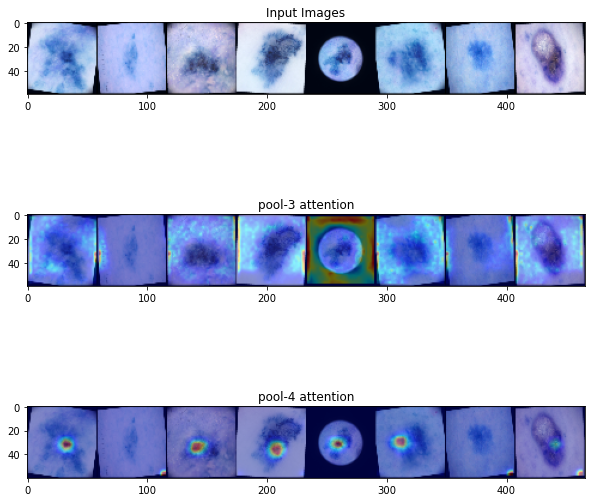

In [17]:
orig=visualize_attention(I_train,a1,up_factor=2,no_attention=True)
first=visualize_attention(I_train,a1,up_factor=2,no_attention=False)
second=visualize_attention(I_train,a2,up_factor=4,no_attention=False)

fig, (ax1, ax2,ax3) = plt.subplots(3, 1,figsize=(10, 10))
ax1.imshow(orig)
ax2.imshow(first)
ax3.imshow(second)
ax1.title.set_text('Input Images')
ax2.title.set_text('pool-3 attention')
ax3.title.set_text('pool-4 attention')

> * **The way this works for malignant images** :- The shallower layer (pool-3) tends to focus on more general and diffused areas, while the deeper layer (pool-4) is more concentrated, focusing on the lesion and avoiding irrelevant objects.
> * But since most images in our case are benign, pool-3 tries to learn some areas but pool-4 eventually minimizes the activated regions because the image is benign.  

## Submission 
Now let's make a submission through our trained model.

In [18]:
model.eval();

result = {'image_name': [], 'target': []}
for images, image_names in tqdm(test_loader, total=len(test_loader)):
    preds=[]
    with torch.no_grad():
        outputs,_,_ = model(images)
        a=torch.sigmoid(outputs).cpu().numpy()
        for i in a:
            preds.append(i[0])

    result['image_name'].extend(image_names)
    result['target'].extend(preds)

submission = pd.DataFrame(result)
submission['image_name']=[x[58:70] for x in submission['image_name']]
submission.to_csv('submission.csv',index=False)
submission.head()

100%|██████████| 220/220 [44:21<00:00, 12.10s/it]


,image_name,target
0,ISIC_0052060,0.306900
1,ISIC_0052349,0.490330
2,ISIC_0058510,0.268871
3,ISIC_0073313,0.285873
4,ISIC_0073502,0.346262


## End Notes

* This kernel is a basic demonstration of how to use Attention mechanism with pretrained image models.
* The paper also claims that due to the elimination of Dense Layers, number of parameters are greatly reduced and the network is lighter to train.
* Tuning the hyperparameters, changing the backbone architecture,increasing training data might yield better results in this competition.

### References
* [https://www2.cs.sfu.ca/~hamarneh/ecopy/ipmi2019.pdf](https://www2.cs.sfu.ca/~hamarneh/ecopy/ipmi2019.pdf)
* https://towardsdatascience.com/learn-to-pay-attention-trainable-visual-attention-in-cnns-87e2869f89f1
* https://github.com/SaoYan/IPMI2019-AttnMel/tree/99e4a9b71717fb51f24d7994948b6a0e76bb8d58

***If you liked the kernel, don't forget to upvote it!***